# Customer Retention and Revenue Analysis


Average Order Value: 2036.73

Orders per customer (summary):
count    219.000000
mean       5.246575
std        4.777952
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max       18.000000
Name: transaction_id, dtype: float64

Top category by revenue:
category
Home Improvement    555919.80
Garden              411975.65
Electronics         407140.19
Seasonal            366051.17
Automotive          355192.09
Camping             243919.49
Name: value, dtype: float64


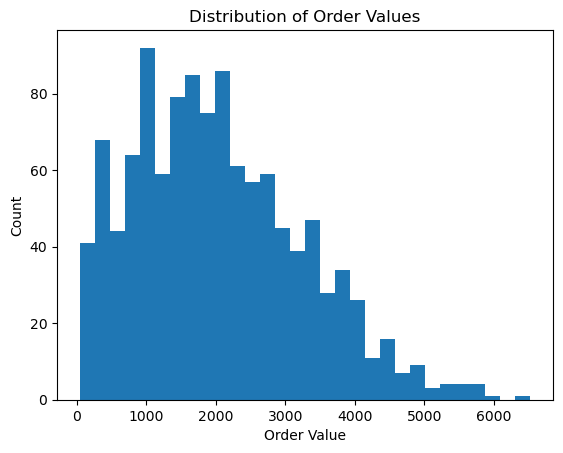

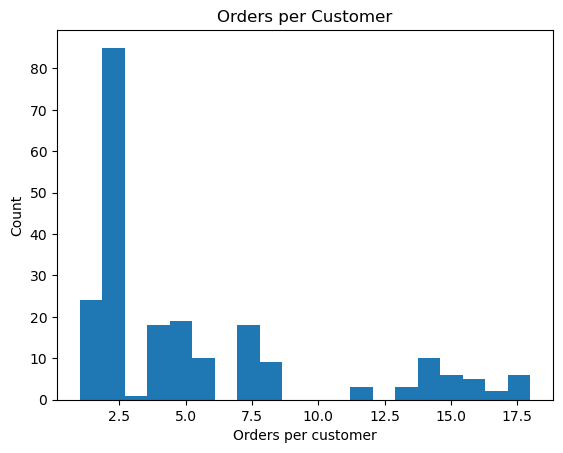

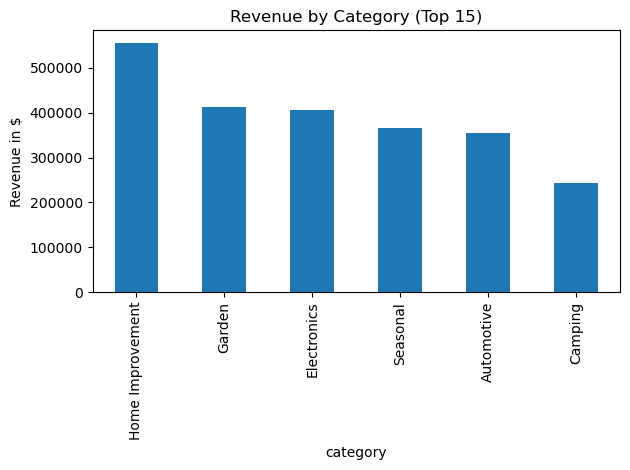

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#  Load and prepare data 
customers = pd.read_excel("Customers.xlsx").rename(columns={
    "CustomerID": "customer_id",
})

products = pd.read_excel("Products.xlsx").rename(columns={
    "ProductID": "product_id",
    "UnitPrice": "unit_price",
    "Category": "category",
    "Type": "type",
    "ProductName": "product_name",
})

transactions = pd.read_excel("Transactions.xlsx").rename(columns={
    "TransactionID": "transaction_id",
    "CustomerID": "customer_id",
    "ProductID": "product_id",
    "Date": "date",
    "Value": "value",
    "Quantity": "quantity",
    "IsRefund": "is_refund",
    "Shop": "shop",
})

shops = pd.read_excel("Shops.xlsx").rename(columns={
    "Shop": "shop",
    "City": "shop_city",
    "ShopType": "shop_type",
})

# Keep only non-refund transactions
transactions = transactions[transactions["is_refund"] != True].copy()

# Merge all datasets
merged = (
    transactions
    .merge(customers, on="customer_id", how="left")
    .merge(products, on="product_id", how="left")
    .merge(shops, on="shop", how="left")
)

#  Purchasing Behaviors Analysis
# Average Order Value (AOV)
orders = merged.groupby("transaction_id", as_index=False).agg(order_revenue=("value", "sum"))
aov = orders["order_revenue"].mean()

# Orders per customer
cust_orders = merged.groupby("customer_id")["transaction_id"].nunique()

# Revenue distribution by category (fallbacks if 'category' missing)
group_col = "category" if "category" in merged.columns else ("type" if "type" in merged.columns else "product_name")
revenue_by_group = merged.groupby(group_col)["value"].sum().sort_values(ascending=False)

print(f"Average Order Value: {aov:.2f}")
print("\nOrders per customer (summary):")
print(cust_orders.describe())
print(f"\nTop {group_col} by revenue:")
print(revenue_by_group.head(15))

# Visualizations
plt.figure()
orders["order_revenue"].plot(kind="hist", bins=30, title="Distribution of Order Values")
plt.xlabel("Order Value")
plt.ylabel("Count")
plt.show()

plt.figure()
cust_orders.plot(kind="hist", bins=20, title="Orders per Customer")
plt.xlabel("Orders per customer")
plt.ylabel("Count")
plt.show()

plt.figure()
revenue_by_group.head(15).plot(kind="bar", title=f"Revenue by {group_col.title()} (Top 15)")
plt.ylabel("Revenue in $")
plt.tight_layout()
plt.show()

RFM head:
  customer_id  recency_days  frequency  monetary  R  F  M RFM_Score    segment
0    25642016            32          6   9092.14  3  3  3       333  Champions
1    51460506            32          5   6085.33  3  3  3       333  Champions
2    00cba229            65          2   2637.21  2  1  2       212    Dormant
3    01017b4a            26         14  46334.53  3  4  4       344  Champions
4    0181f347           223          2   1188.46  1  1  1       111    Dormant

Segment counts:
segment
Champions        72
Dormant          71
At Risk Loyal    32
Loyal            25
Others           12
New Customers     7
Name: count, dtype: int64


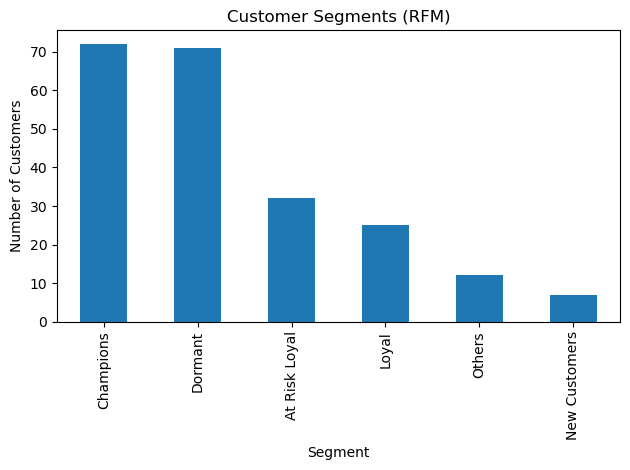

In [13]:
import numpy as np

# Ensure date is datetime
merged["date"] = pd.to_datetime(merged["date"])

# Snapshot date = day after last purchase
snapshot_date = merged["date"].max() + pd.Timedelta(days=1)

# RFM calculation 
rfm = merged.groupby("customer_id").agg(
    recency_days=("date", lambda x: (snapshot_date - x.max()).days),
    frequency=("transaction_id", "nunique"),
    monetary=("value", "sum")
).reset_index()

# Score each metric from 1 (low) to 4 (high)
rfm["R"] = pd.qcut(rfm["recency_days"].rank(method="first"), 4, labels=[4,3,2,1]).astype(int)
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)
rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)

# Combine into RFM Score
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

# Segment labeling function
def rfm_segment(row):
    if row["R"] >= 3 and row["F"] >= 3 and row["M"] >= 3:
        return "Champions"
    if row["R"] >= 3 and row["F"] >= 2:
        return "Loyal"
    if row["R"] >= 3 and row["M"] >= 3:
        return "Big Spenders"
    if row["R"] == 4 and row["F"] == 1:
        return "New Customers"
    if row["R"] <= 2 and row["F"] >= 3:
        return "At Risk Loyal"
    if row["R"] <= 2 and row["M"] <= 2 and row["F"] <= 2:
        return "Dormant"
    return "Others"

rfm["segment"] = rfm.apply(rfm_segment, axis=1)

print("RFM head:")
print(rfm.head())

print("\nSegment counts:")
print(rfm["segment"].value_counts())

#  Visualization 
plt.figure()
rfm["segment"].value_counts().plot(kind="bar", title="Customer Segments (RFM)")
plt.ylabel("Number of Customers")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

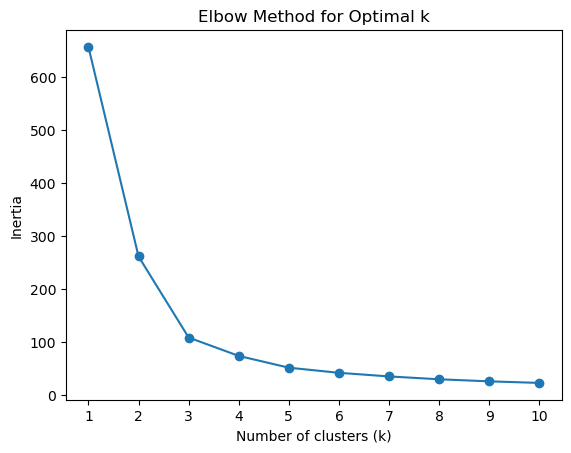

         recency_days  frequency      monetary
cluster                                       
0           56.136986   3.780822   5493.118082
1           27.314286  15.057143  40832.654286
2          252.078947   1.842105   2870.006579


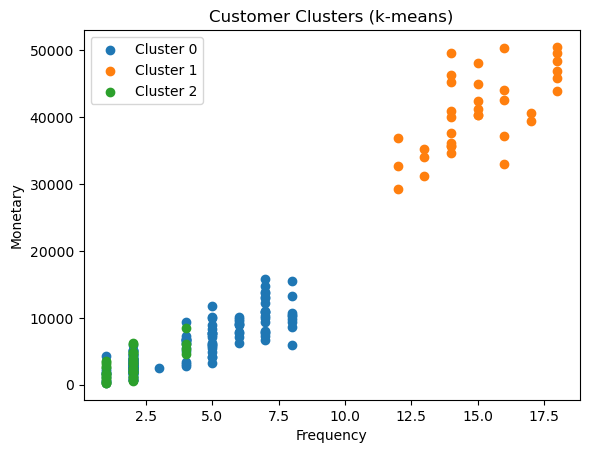

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#  Prepare customer-level metrics 
cust_metrics = merged.groupby("customer_id").agg(
    recency_days=("date", lambda x: (snapshot_date - x.max()).days),
    frequency=("transaction_id", "nunique"),
    monetary=("value", "sum")
).reset_index()

#  Scale the features 
X = cust_metrics[["recency_days", "frequency", "monetary"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Elbow method to choose k 
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.xticks(K_range)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

#  Choose k based on elbow 
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cust_metrics["cluster"] = kmeans.fit_predict(X_scaled)

#  Inspect clusters 
print(cust_metrics.groupby("cluster")[["recency_days", "frequency", "monetary"]].mean())

#  Plot clusters (frequency vs monetary as example) 
plt.figure()
for cluster_id in sorted(cust_metrics["cluster"].unique()):
    cluster_data = cust_metrics[cust_metrics["cluster"] == cluster_id]
    plt.scatter(cluster_data["frequency"], cluster_data["monetary"], label=f"Cluster {cluster_id}")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Customer Clusters (k-means)")
plt.legend()
plt.show()

segment  At Risk Loyal  Champions  Dormant  Loyal  New Customers  Others
cluster                                                                 
0                   23         42       40     25              7       9
1                    5         30        0      0              0       0
2                    4          0       31      0              0       3

Percentage breakdown:
segment  At Risk Loyal  Champions  Dormant  Loyal  New Customers  Others
cluster                                                                 
0                 0.16       0.29     0.27   0.17           0.05    0.06
1                 0.14       0.86     0.00   0.00           0.00    0.00
2                 0.11       0.00     0.82   0.00           0.00    0.08


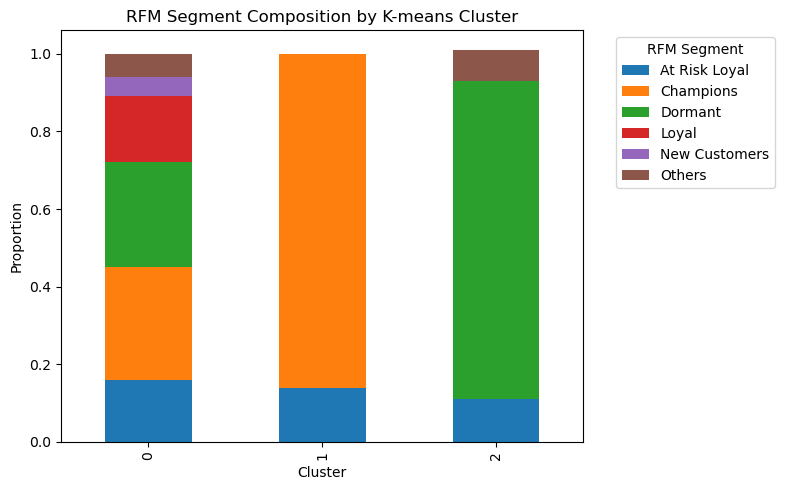

In [5]:
# Merge k-means clusters with RFM segments
rfm_with_clusters = rfm.merge(
    cust_metrics[["customer_id", "cluster"]],
    on="customer_id",
    how="left"
)

# Check how clusters map to RFM segments
cluster_segment_table = pd.crosstab(rfm_with_clusters["cluster"], rfm_with_clusters["segment"])
print(cluster_segment_table)

# Optional: normalize to percentages for easier reading
cluster_segment_pct = cluster_segment_table.div(cluster_segment_table.sum(axis=1), axis=0).round(2)
print("\nPercentage breakdown:")
print(cluster_segment_pct)

# Visualize cluster-to-segment mapping
cluster_segment_pct.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("RFM Segment Composition by K-means Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="RFM Segment", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Median gap: 0 days, 75th: 0, 90th: 31
Recommended churn trigger ≈ 90 days since last purchase

Cluster-specific 75th percentile gaps and recommended triggers:
         p75_days  recommended_trigger_days
cluster                                    
0              10                        90
1               0                        90
2               0                        90


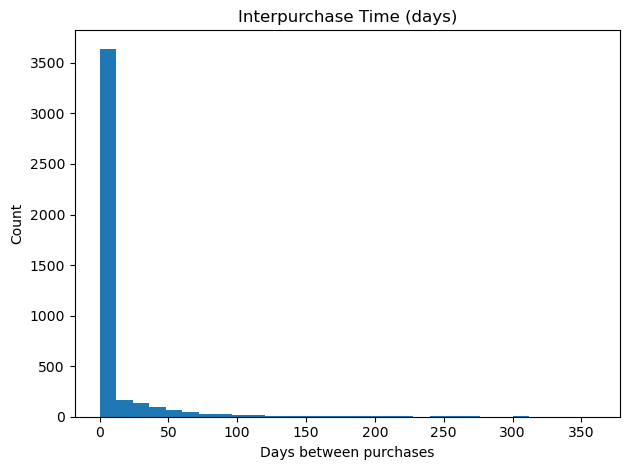

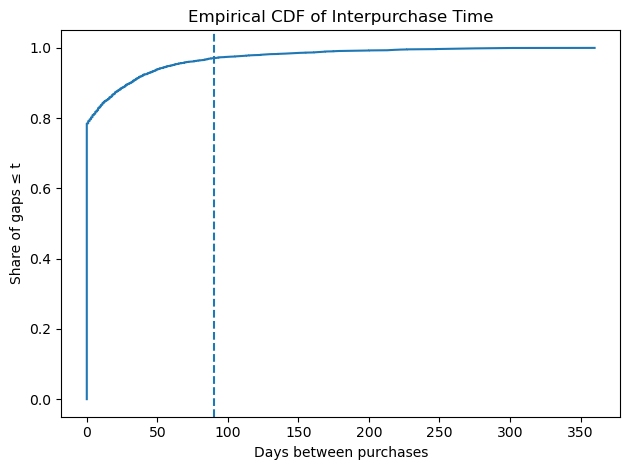


Customers currently at risk (days_since_last ≥ 90): 74 of 219
            last_purchase  days_since_last  at_risk_flag
customer_id                                             
0181f347       2024-05-23              223          True
023bebd8       2024-06-16              199          True
05c7a2ff       2024-07-22              163          True
143e3b8c       2024-09-22              101          True
17025f8c       2024-02-16              320          True
1bc9f648       2024-01-12              355          True
2b1d6a23       2024-09-16              107          True
2e6ca84e       2024-09-12              111          True
3034d988       2024-04-26              250          True
32a3962c       2024-07-05              180          True


In [19]:

merged["date"] = pd.to_datetime(merged["date"])

# Sort and compute interpurchase gaps per customer
g = merged.sort_values(["customer_id", "date"]).copy()
g["prev_date"] = g.groupby("customer_id")["date"].shift(1)
g["gap_days"] = (g["date"] - g["prev_date"]).dt.days
gaps = g.dropna(subset=["gap_days"])["gap_days"].astype(int)

# Basic gap stats
p50 = np.percentile(gaps, 50) if len(gaps) else np.nan
p75 = np.percentile(gaps, 75) if len(gaps) else np.nan
p90 = np.percentile(gaps, 90) if len(gaps) else np.nan

# Churn trigger: max(75th percentile, 90 days)
churn_threshold = int(max(p75 if not np.isnan(p75) else 0, 90))
print(f"Median gap: {p50:.0f} days, 75th: {p75:.0f}, 90th: {p90:.0f}")
print(f"Recommended churn trigger ≈ {churn_threshold} days since last purchase")

# Cluster-specific thresholds 
if 'cust_metrics' in globals() and 'cluster' in cust_metrics.columns:
    # Map each gap to the customer's cluster
    last_cluster_map = cust_metrics.set_index("customer_id")["cluster"]
    g["cluster"] = g["customer_id"].map(last_cluster_map)
    cluster_thresholds = (
        g.dropna(subset=["gap_days", "cluster"])
         .groupby("cluster")["gap_days"]
         .quantile(0.75)
         .astype(int)
         .rename("p75_days")
         .to_frame()
    )
    cluster_thresholds["recommended_trigger_days"] = cluster_thresholds["p75_days"].apply(lambda x: max(x, 90))
    print("\nCluster-specific 75th percentile gaps and recommended triggers:")
    print(cluster_thresholds)

# Plot gap distribution
plt.figure()
gaps.plot(kind="hist", bins=30, title="Interpurchase Time (days)")
plt.xlabel("Days between purchases")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Empirical CDF to see where returns slow down
plt.figure()
sorted_gaps = np.sort(gaps)
ecdf = np.arange(1, len(sorted_gaps)+1) / len(sorted_gaps)
plt.plot(sorted_gaps, ecdf)
plt.axvline(churn_threshold, linestyle="--")
plt.title("Empirical CDF of Interpurchase Time")
plt.xlabel("Days between purchases")
plt.ylabel("Share of gaps ≤ t")
plt.tight_layout()
plt.show()

# Flag currently at-risk customers using the chosen trigger
snapshot_date = merged["date"].max() + pd.Timedelta(days=1)
last_purchase = merged.groupby("customer_id")["date"].max().rename("last_purchase")
days_since_last = (snapshot_date - last_purchase).dt.days.rename("days_since_last")
at_risk = pd.concat([last_purchase, days_since_last], axis=1)
at_risk["at_risk_flag"] = at_risk["days_since_last"] >= churn_threshold

print(f"\nCustomers currently at risk (days_since_last ≥ {churn_threshold}): {at_risk['at_risk_flag'].sum()} of {len(at_risk)}")
print(at_risk[at_risk["at_risk_flag"]].head(10))